In [98]:
##Data Manipulation
import pandas as pd
import numpy as np
from pandas import DataFrame,Series

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path

##Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge,LassoCV,RidgeCV,ElasticNetCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
from sklearn.compose import ColumnTransformer
import pickle



## Data extraction and Data Cleaning

In [23]:
url='C:\\Users\\HP\\Downloads\\Ridge+Lassso+Elastic+Regression+Practicals\\Ridge Lassso Elastic Regression Practicals\\Algerian_forest_fires_dataset_UPDATE.csv'
fire_df=pd.read_csv(url,header=1)

In [24]:
def data_convert_clean(data_location,folder_name="notebook"):
    # Define numeric columns
    num_cols1 = ['day', 'month', 'year', 'temperature', 'rh', 'ws']
    num_cols2 = ['rain', 'ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi']
    
    # Read data
    df = pd.read_csv(data_location, header=1)
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Find rows where all but the first column are NaN (separator rows)
    del_row = df[df.iloc[:, 1:].isnull().all(axis=1)].index
    
    split_point = None
    if not del_row.empty:
        split_point = del_row[0]   # first separator row index
        df = df.drop(index=del_row).reset_index(drop=True)
        df = df.drop(index=del_row).reset_index(drop=True)
    
    # Convert integer-like cols
    df[num_cols1] = df[num_cols1].astype('Int64')
    
    # Find invalid entries in numeric columns
    mask = ~df[num_cols2].applymap(
        lambda x: str(x).replace('.', '', 1).replace('-', '', 1).isdigit()
    )
    bad_idx = df[mask.any(axis=1)].index.tolist()
    
    for i in bad_idx:
        wrong_val = df.iloc[i, -2]  # second-to-last col (fwi)
        # Convert if numeric, else set NaN
        df.iloc[i, -2] = (
            float(wrong_val) if str(wrong_val).replace('.', '', 1).isdigit() else np.nan
        )
        # Fill last column (classes) if missing
        if pd.isna(df.iloc[i, -1]):
            df.iloc[i, -1] = df.iloc[:, -1].mode()[0]
    
    # Final conversion of numeric cols
    df[num_cols2] = df[num_cols2].replace(r'\s+', '', regex=True).astype(float)
    
    # Region assignment (dynamic)
    if split_point is not None:
        df.loc[:split_point-1, 'region'] = 'Bejaia'
        df.loc[split_point:, 'region'] = 'Sidi-Bel Abbes'
    
    # Clean class labels
    df['classes'] = df['classes'].str.strip()

    save_dir=Path(folder_name)
    save_dir.mkdir(parents=True,exist_ok=True)
    
    save_path=save_dir/"Clean_Fire_data.csv"

    df.to_csv(save_path,index=False)
    
    return df,save_path


# EDA and Feature Engineering


1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012)
Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH : Relative Humidity in %: 21 to 90
4. Ws :Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8
FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely Fire and not Fire

In [25]:
fire_df=pd.read_csv("Clean_Fire_data.csv")
fire_df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,244.0,15.754098,8.825059,1.0,8.000,16.00,23.000,31.0
month,244.0,7.500000,1.112961,6.0,7.000,7.50,8.000,9.0
year,244.0,2012.000000,0.000000,2012.0,2012.000,2012.00,2012.000,2012.0
temperature,244.0,32.172131,3.633843,22.0,30.000,32.00,35.000,42.0
rh,244.0,61.938525,14.884200,21.0,52.000,63.00,73.250,90.0
ws,244.0,15.504098,2.810178,6.0,14.000,15.00,17.000,29.0
rain,244.0,0.760656,1.999406,0.0,0.000,0.00,0.500,16.8
ffmc,244.0,77.887705,14.337571,28.6,72.075,83.50,88.300,96.0
dmc,244.0,14.673361,12.368039,0.7,5.800,11.30,20.750,65.9
dc,244.0,49.288484,47.619393,6.9,13.275,33.10,68.150,220.4


In [26]:
fire_df['classes'].value_counts()

classes
fire        138
not fire    106
Name: count, dtype: int64

### univariate analysis

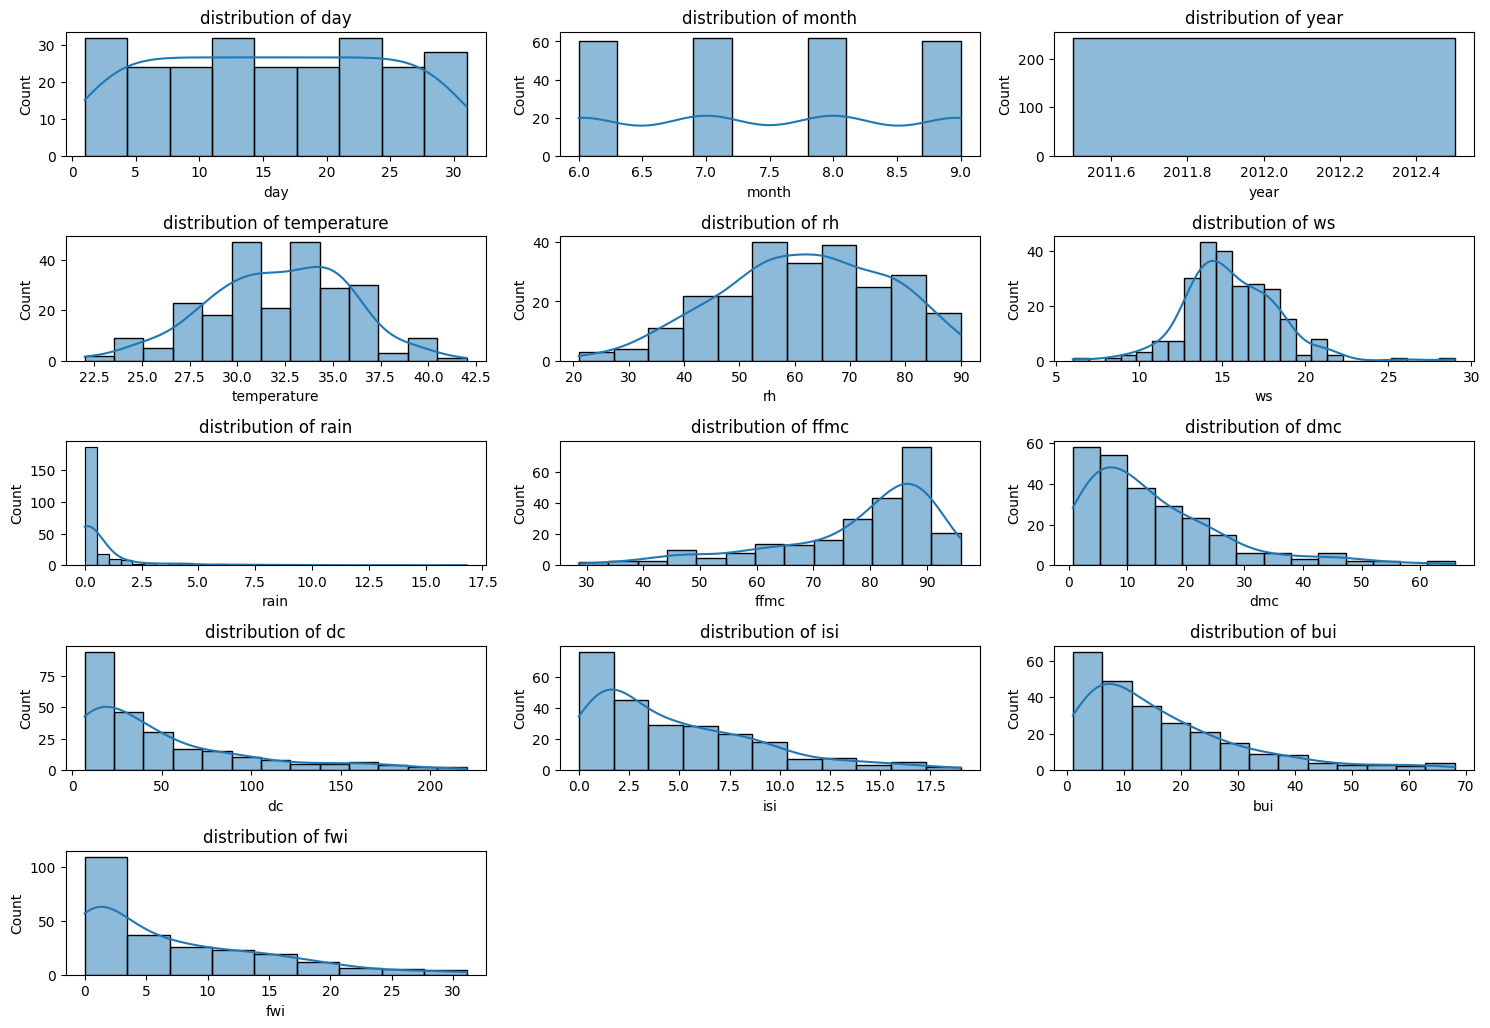

In [27]:
numeric_cols=fire_df.select_dtypes(include='number').columns

plt.figure(figsize=(15,12))

for i,col in enumerate(numeric_cols,1):
    plt.subplot(len(numeric_cols)//3+2,3,i)
    sns.histplot(fire_df[col],kde=True,cbar='skyblue')
    plt.title(f'distribution of {col}')
    plt.tight_layout()
plt.show()

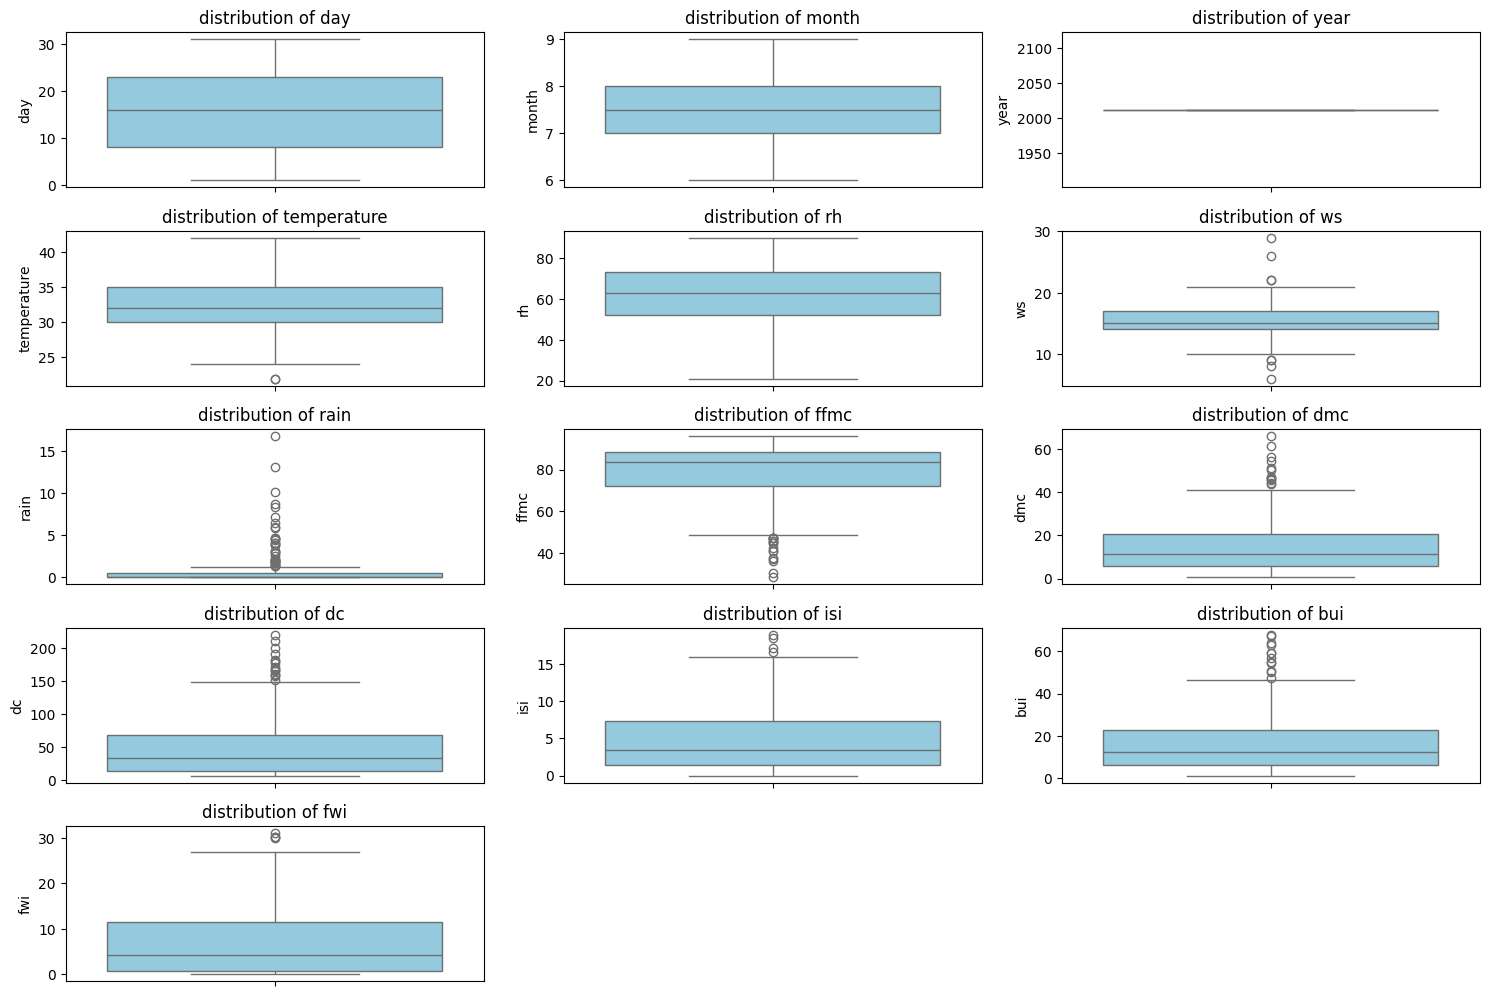

In [28]:
plt.figure(figsize=(15,12))

for i,col in enumerate(numeric_cols,1):
    plt.subplot(len(numeric_cols)//3+2,3,i)
    sns.boxplot(fire_df[col],color='skyblue')
    plt.title(f'distribution of {col}')
    plt.tight_layout()
plt.show()

## bivariate analysis

In [29]:
fire_df.head()

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia


In [30]:
fire_df.month.value_counts()

month
7    62
8    62
6    60
9    60
Name: count, dtype: int64

In [31]:
## which month had more fires
fig = px.bar(
    fire_df,
    x="month",
    y="rain",
    color="classes",   # hue in seaborn = color in plotly express
    barmode="group"    # to keep bars side-by-side like seaborn default
)

fig.show()


Months with less rain have more fire outbreaks

In [32]:
DataFrame(fire_df.groupby("classes")["region"].value_counts(normalize=True)*100).reset_index()


,classes,region,proportion
0,fire,Sidi-Bel Abbes,57.246377
1,fire,Bejaia,42.753623
2,not fire,Bejaia,59.433962
3,not fire,Sidi-Bel Abbes,40.566038


There are more fires in Sidi-Bel Abbes compared to Bejaia...

In [33]:
dep_df=DataFrame(fire_df.groupby("classes")[["region",'month']].value_counts()).reset_index()

In [34]:
dep_df

,classes,region,month,count
0,fire,Sidi-Bel Abbes,8,27
1,fire,Bejaia,8,24
2,fire,Sidi-Bel Abbes,7,24
3,fire,Sidi-Bel Abbes,9,16
4,fire,Bejaia,7,15
5,fire,Bejaia,6,13
6,fire,Sidi-Bel Abbes,6,12
7,fire,Bejaia,9,7
8,not fire,Bejaia,9,23
9,not fire,Sidi-Bel Abbes,6,18


In [35]:


fig = px.bar(
    dep_df[dep_df['region']=='Sidi-Bel Abbes'],  # replace with your grouped DataFrame
    x="month",
    y="count",
    color="classes",
    barmode="group",
    title="Sidi-Bel Abbes Month-on-Month Fires"
)
fig.show()

In [36]:

fig = px.bar(
    dep_df[dep_df['region']=='Bejaia'],  # replace with your grouped DataFrame
    x="month",
    y="count",
    color="classes",
    barmode="group",
    title="Bejaia Month-on-Month Fires"
)
fig.show()

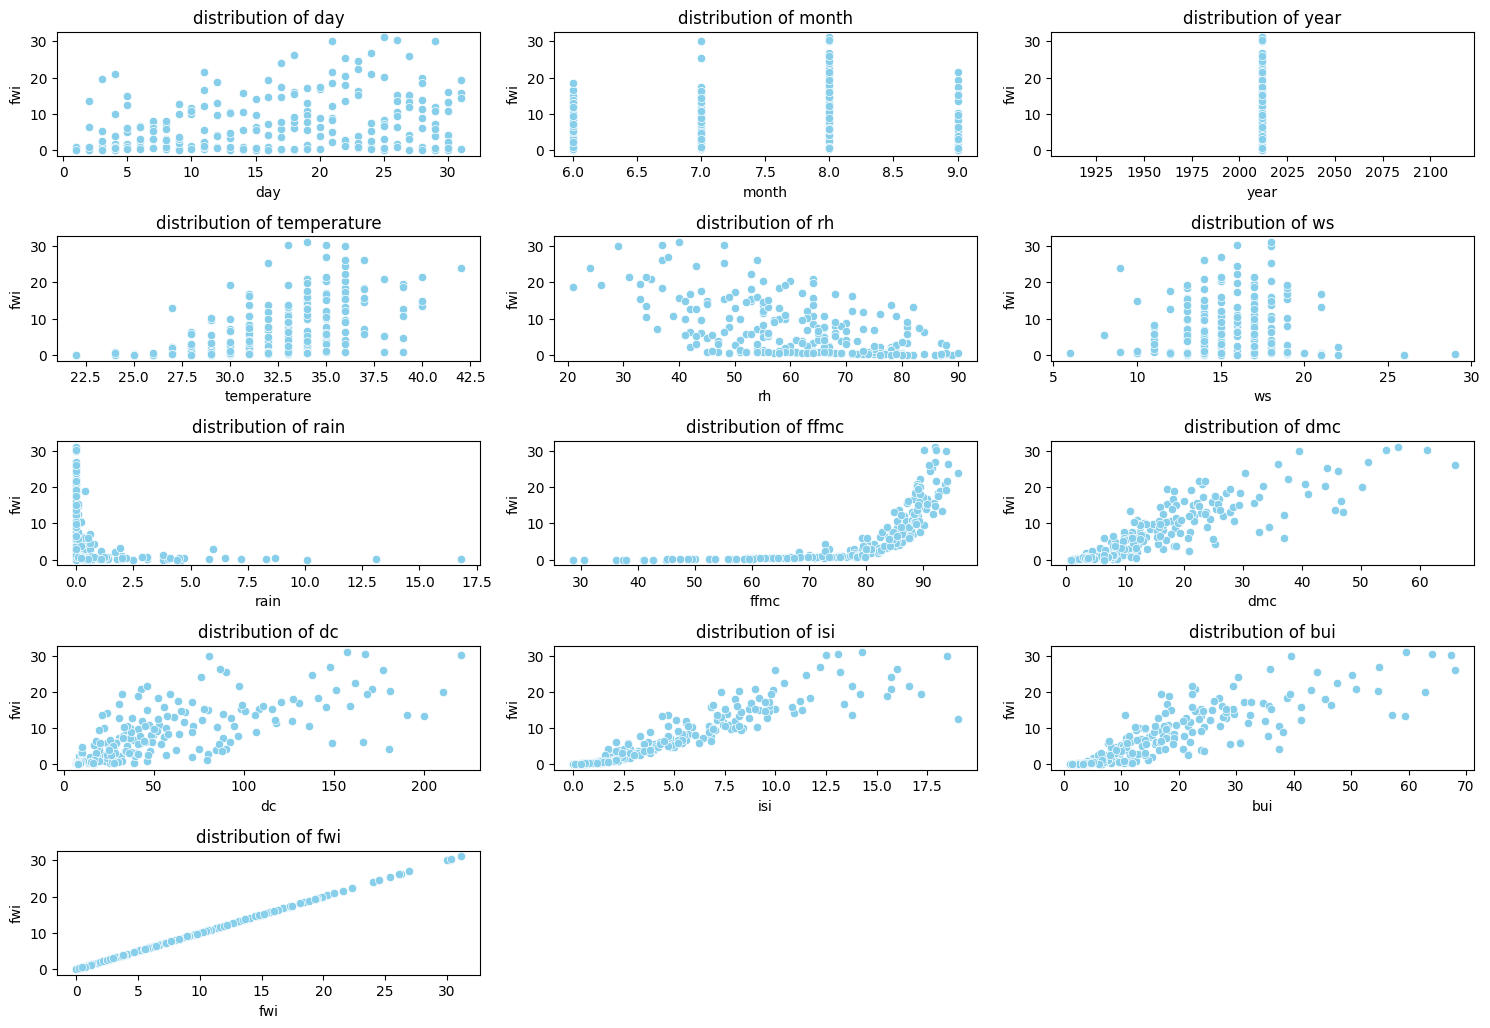

In [37]:
numeric_cols=fire_df.select_dtypes(include='number').columns

plt.figure(figsize=(15,12))

for i,col in enumerate(numeric_cols,1):
    plt.subplot(len(numeric_cols)//3+2,3,i)
    sns.scatterplot(x=fire_df[col],y=fire_df['fwi'],c='skyblue')
    plt.title(f'distribution of {col}')
    plt.tight_layout()
plt.show()

In [38]:
fig = px.bar(
    fire_df,
    x="day",
    y="fwi",
    color="region",   # hue in seaborn = color in plotly express
    barmode="group"    # to keep bars side-by-side like seaborn default
)

fig.show()

In [39]:
fire_df.select_dtypes(include='number').corr()['fwi']

day            0.350928
month          0.083001
year                NaN
temperature    0.570143
rh            -0.582983
ws             0.032428
rain          -0.324506
ffmc           0.691381
dmc            0.875876
dc             0.739608
isi            0.922895
bui            0.857980
fwi            1.000000
Name: fwi, dtype: float64

C:\Users\HP\AppData\Local\Temp\ipykernel_6380\2898338822.py:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



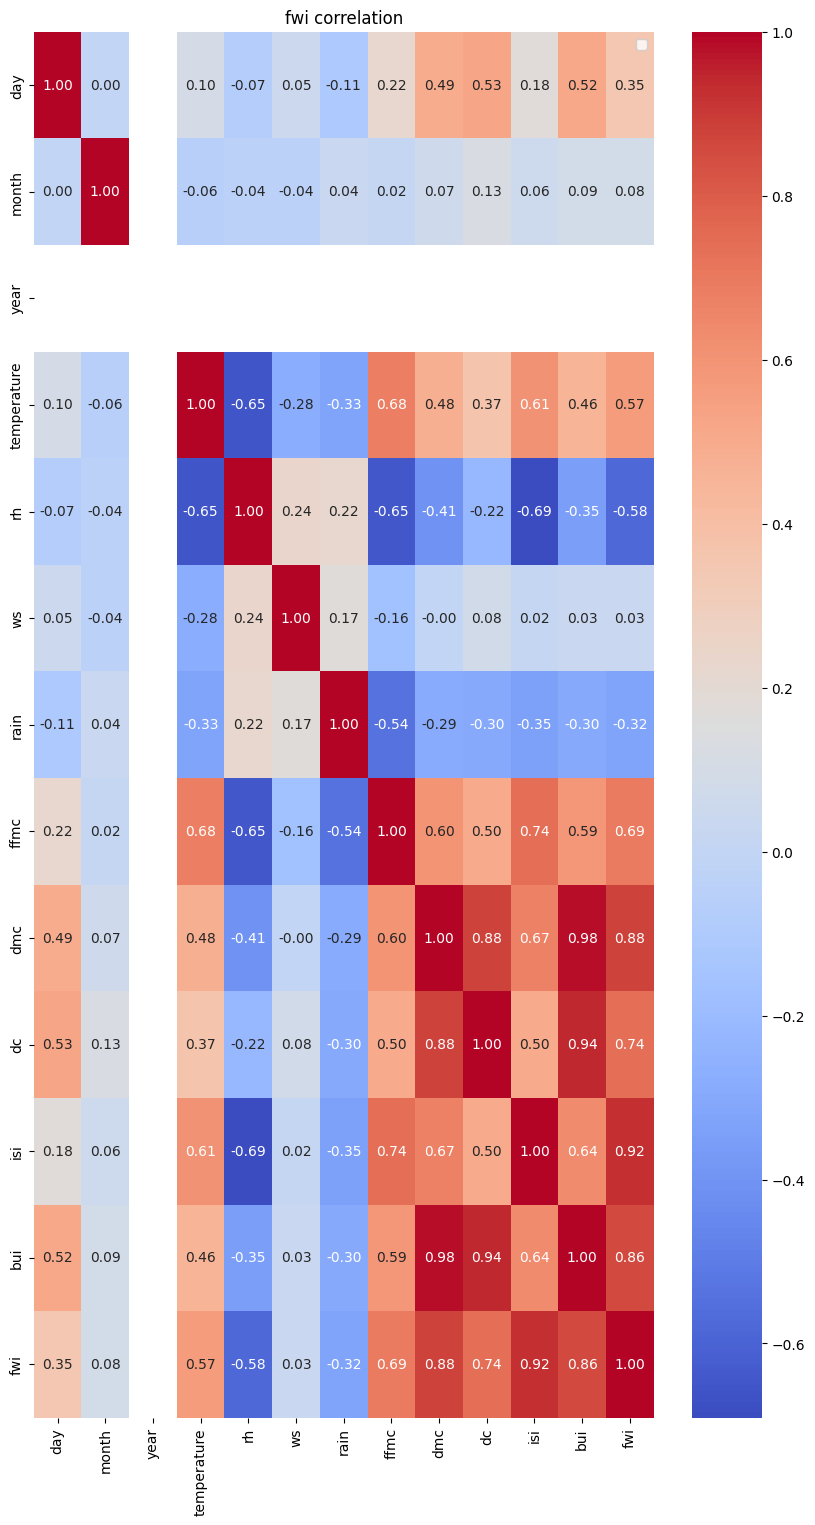

In [40]:
corr_matx=fire_df.select_dtypes(include='number').corr().T

plt.figure(figsize=(10,18))
sns.heatmap(corr_matx,annot=True,cmap='coolwarm',fmt='.2f',cbar=True)
plt.title('fwi correlation')
plt.legend()
plt.show()

## Feature Engineering

In [ ]:
def read_data(filepath):
    data_path=Path(filepath)
    if not data_path.exists():
        raise FileNotFoundError(f'Folder is empty please check{str(data_path)}')
    
    files=[file for file in data_path.glob("*.csv")]
    if not files:
        raise ValueError(f'Folder is empty please check{str(data_path)}')
        
    raw_data=[pd.read_csv(file) for file in files]
    df=pd.concat(raw_data,ignore_index=False)
    return df

In [52]:
df_fire=read_data("C:\\Users\\HP\\Desktop\\Data Projects\\E2E ML\\notebook")

In [42]:
fire_df.head()

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia


In [43]:
fire_df=fire_df.drop(columns=['day','month','year'])

In [90]:
num_cols=fire_df.select_dtypes(include='number').columns.drop('fwi').to_list()
cat_cols=['region']

In [45]:
fire_df.head()

,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia


In [46]:
df_train,df_tmp=train_test_split(fire_df,test_size=0.4,random_state=42)
df_valid,df_test=train_test_split(df_tmp,test_size=0.5,random_state=42)

X_train=df_train.drop(columns=['classes','fwi'])
y_train=df_train['fwi']

X_valid=df_valid.drop(columns=['classes','fwi'])
y_valid=df_valid['fwi']

X_test=df_test.drop(columns=['classes','fwi'])
y_test=df_test['fwi']

In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_trans=make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())
cat_trans=make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder())

feature_transform=ColumnTransformer(
    transformers=[
        ('num',num_trans,num_cols),
        ('cat',cat_trans,cat_cols)
    ]
)

In [119]:
def split_data(df,target):
    unused_cols=['day','month','year']
    df=df.drop(columns=unused_cols)
    
    df_train,df_tmp=train_test_split(df,test_size=0.4,random_state=42)
    df_valid,df_test=train_test_split(df_tmp,test_size=0.5,random_state=42)

    X_train=df_train.drop(columns=['classes',target])
    y_train=df_train[target]

    X_valid=df_valid.drop(columns=['classes',target])
    y_valid=df_valid[target]

    X_test=df_test.drop(columns=['classes',target])
    y_test=df_test[target]

    return X_train,y_train,X_valid,y_valid,X_test,y_test

    

In [120]:
X_train,y_train,X_valid,y_valid,X_test,y_test=split_data(df_fire,'fwi')

In [116]:
y_train.fillna(y_train.mean())

194    18.8
76      4.2
41      0.9
108     5.9
223     0.3
       ... 
106     0.0
14      0.1
92      0.1
179     9.0
102     0.3
Name: fwi, Length: 146, dtype: float64

In [75]:
Path.cwd()

WindowsPath('c:/Users/HP/Desktop/Data Projects/E2E ML/notebook')

In [121]:
def save_split(X_train,y_train,X_valid,y_valid,X_test,y_test):
    train=np.concatenate((X_train, y_train.to_numpy().reshape(-1,1)), axis=1)
    valid=np.concatenate((X_valid, y_valid.to_numpy().reshape(-1, 1)), axis=1)
    test=np.concatenate((X_test, y_test.to_numpy().reshape(-1, 1)), axis=1)

    save_dir=Path(Path.cwd())
    save_dir.mkdir(parents=True,exist_ok=True)

    train_path=save_dir/"train.csv"
    test_path=save_dir/"test.csv"
    valid_path=save_dir/"valid.csv"

    pd.DataFrame(train).to_csv(train_path,index=False)
    pd.DataFrame(valid).to_csv(valid_path,index=False)
    pd.DataFrame(test).to_csv(test_path,index=False)



   

In [ ]:
path1 = r"C:\Users\HP\Desktop\Data Projects\E2E ML"
path2 = "save_models"

full_path=os.path.join(path1,path2)
print(full_path)

In [122]:
def feature_eng(X_train,y_train,X_valid,y_valid,X_test,y_test,full_path):

    num_cols=X_train.select_dtypes(include='number').columns.to_list()
    cat_cols=['region']
    
    num_trans=make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())
    cat_trans=make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder())

    feature_transform=ColumnTransformer(
        transformers=[
            ('num',num_trans,num_cols),
            ('cat',cat_trans,cat_cols)
        ]
    )

    X_train=feature_transform.fit_transform(X_train)
    X_valid=feature_transform.transform(X_valid)
    X_test=feature_transform.transform(X_test)

    y_train=y_train.fillna(y_train.mean())
    y_valid=y_valid.fillna(y_valid.mean())
    y_test=y_test.fillna(y_test.mean())

    
    save_dir=Path(full_path)
    save_dir.mkdir(parents=True,exist_ok=True)
    transformer_path = save_dir / "feature_transformer.pkl"

    with open(transformer_path,"wb") as pkfile:
        pickle.dump(feature_transform,pkfile)

    return X_train,y_train,X_valid,y_valid,X_test,y_test


In [123]:
X_train,y_train,X_valid,y_valid,X_test,y_test=feature_eng(X_train,y_train,X_valid,y_valid,X_test,y_test,full_path)

In [97]:
path1 = r"C:\Users\HP\Desktop\Data Projects\E2E ML"
path2 = "save_models"

full_path=os.path.join(path1,path2)
print(full_path)



C:\Users\HP\Desktop\Data Projects\E2E ML\save_models


In [124]:
def train_model(X_train,y_train,X_valid,y_valid):
    y_train = np.ravel(y_train)
    y_valid = np.ravel(y_valid)

    Rd=RidgeCV(cv=5)
    Rd.fit(X_train,y_train)

    pred=Rd.predict(X_valid)
    mae=mean_absolute_error(y_valid,pred)
    r2=r2_score(y_valid,pred)

    print('mean absolute error',mae)
    print('r2 score',r2)

    save_dir=Path(full_path)
    save_dir.mkdir(parents=True,exist_ok=True)
    model_path = save_dir / "model.pkl"

    with open(model_path,"wb") as pkfile:
        pickle.dump(Rd,pkfile)
    
    return Rd


    

In [125]:
train_model(X_train,y_train,X_valid,y_valid)

mean absolute error 0.6709169823059581
r2 score 0.9864666673194242


,alphas,"(0.1, ...)"
,fit_intercept,True
,scoring,None
,cv,5
,gcv_mode,None
,store_cv_results,False
,alpha_per_target,False


In [127]:
save_dir=Path(full_path)
save_dir.mkdir(parents=True,exist_ok=True)
model_path = save_dir / "model.pkl"

In [128]:
model_path

WindowsPath('C:/Users/HP/Desktop/Data Projects/E2E ML/save_models/model.pkl')

In [131]:
with open(model_path,"rb")as pkfile:
    load_model=pickle.load(pkfile)


y_pred=load_model.predict(X_test)

In [48]:
X_train=feature_transform.fit_transform(X_train)
X_valid=feature_transform.transform(X_valid)
X_valid_test=feature_transform.transform(X_test)

#y_train=num_trans.fit_transform(y_train)
#y_valid=num_trans.transform(y_valid)
#y_test=num_trans.transform(y_test)


In [49]:
Lr=LinearRegression()
Lr.fit(X_train,y_train)
pred=Lr.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)


mean absolute error 0.6700310452818115
r2 score 0.9864409546636135


In [50]:
Ls=Lasso()
Ls.fit(X_train,y_train)
pred=Ls.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)

mean absolute error 1.4504518825695252
r2 score 0.9369806581801852


In [51]:
Lac=LassoCV(cv=5)
Lac.fit(X_train,y_train)
pred=Lac.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)

mean absolute error 0.7383504823929773
r2 score 0.9825536554249488


In [52]:
Rd=Ridge()
Rd.fit(X_train,y_train)
pred=Rd.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)

mean absolute error 0.6865374625909303
r2 score 0.9860014554510448


In [53]:
Rd=RidgeCV(cv=5)
Rd.fit(X_train,y_train)
pred=Rd.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)

mean absolute error 0.6704331457895033
r2 score 0.9864679963308103


In [54]:
EL=ElasticNet()
EL.fit(X_train,y_train)
pred=EL.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)

mean absolute error 2.036419288062339
r2 score 0.88203901563226


In [55]:
ELcv=ElasticNetCV(cv=5)
ELcv.fit(X_train,y_train)
pred=ELcv.predict(X_valid)
mae=mean_absolute_error(y_valid,pred)
r2=r2_score(y_valid,pred)
print('mean absolute error',mae)
print('r2 score',r2)

mean absolute error 0.6965467483210503
r2 score 0.9852747711460678


In [56]:
import pickle
with open('reg_model.pkl',"wb") as pkfile:
    pickle.dump(Rd,pkfile)
    

In [58]:
with open("reg_model.pkl","rb")as pkfile:
    load_model=pickle.load(pkfile)


y_pred=load_model.predict(X_valid)